In [64]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline  
import os
import glob
from utils import *
import matplotlib.pyplot as plt
from ast import literal_eval
import pandas as pd
import datetime as dt
plt.rcParams['axes.facecolor']='w'
plt.rcParams['figure.facecolor'] = 'w'
import math
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 16

In [2]:
scored_full = TweetsDataFrame.read_csv('./scored_tweets/scored_270_4528_sorted.csv')
scored_full['createdAt'] =  scored_full.index
scored=scored_full[constants.STARTDATE:constants.FIRST_ROUND]
scored = scored.filter(['createdAt', 'user_id', 'candidate_ref', 'score_neg', 'score_pos'])

In [30]:
only_pos = scored[scored['score_neg']+scored['score_pos'] > 4]
only_neg = scored[scored['score_neg'] + scored['score_pos'] < 0]

In [87]:
def get_polls(df):
    votes = df.groupby('user_id').last().groupby('candidate_ref').count()
    return pd.DataFrame(votes).transpose()
    #pct = votes['createdAt'].div(votes['createdAt'].sum())*100
    #pct.name = df.index.max()
    #return pd.DataFrame(pct).transpose()

def generate_polls(dataframe, bdate, edate, step):
    polls = pd.DataFrame()
    time = bdate
    end = edate
    time_step = step
    while time < end:
        new_polls = get_polls(dataframe[time-2*time_step:time])
        if polls.empty:
            polls = new_polls
        else:
            polls = polls.append(new_polls)

        time += time_step
    return polls

In [32]:
only_pos[:constants.SECOND_ROUND-dt.timedelta(days=1)].groupby('user_id').last().count()

createdAt        274292
candidate_ref    274292
score_neg        274292
score_pos        274292
dtype: int64

### Votes including all the opinions

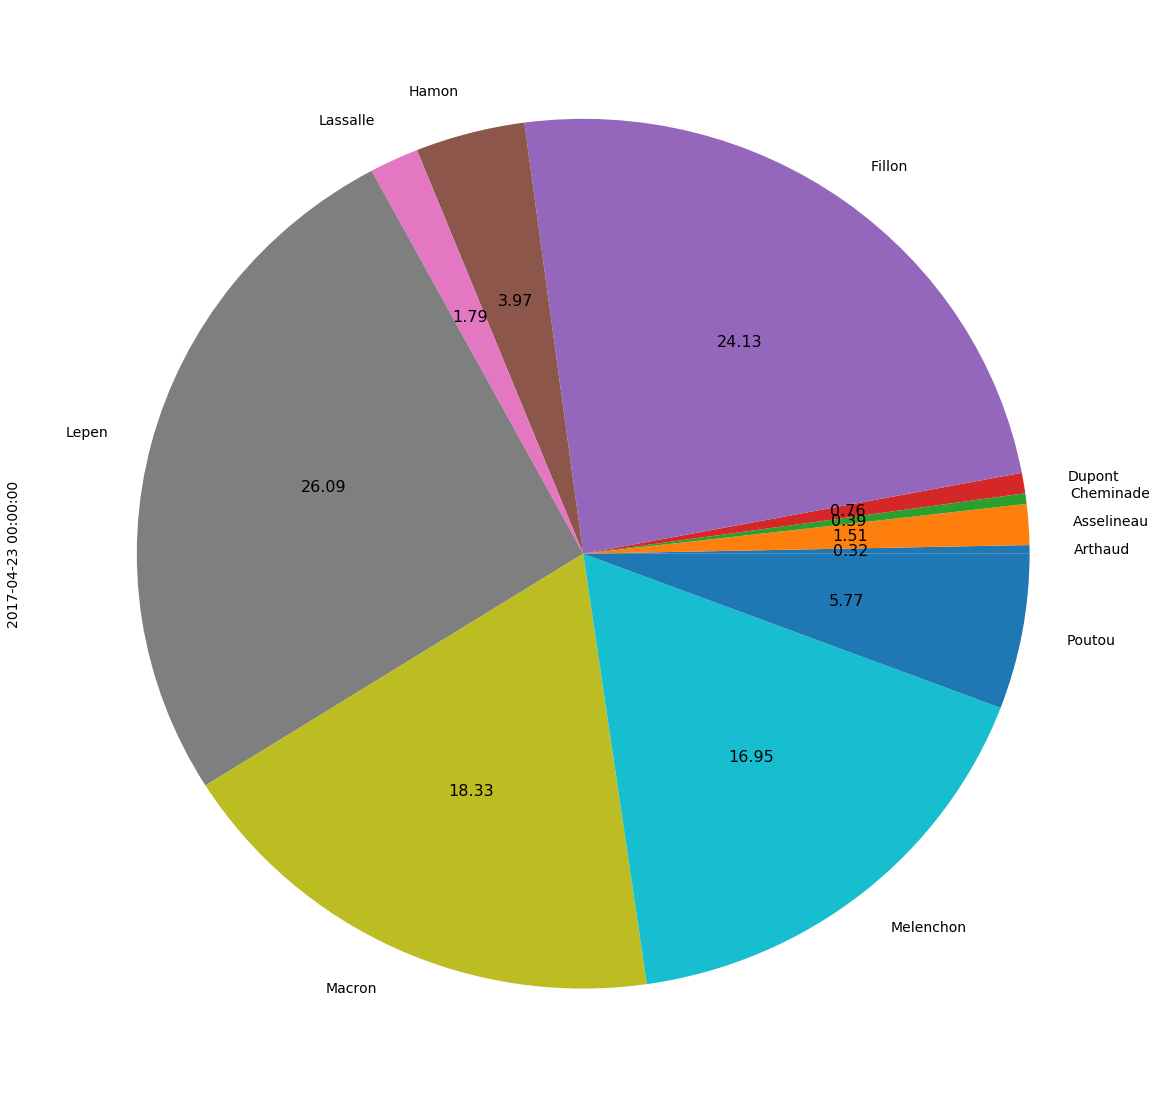

In [65]:
get_polls(only_pos[:constants.FIRST_ROUND]).transpose().plot.pie(0, autopct='%.2f',figsize=(20,20), legend=False)
plt.show()

## Time serie

In [41]:
begin = constants.STARTDATE
step = dt.timedelta(days=1)
end = constants.FIRST_ROUND-step

polls = generate_polls(only_pos, begin, end, step)

In [42]:
polls.iloc[-1]

candidate_ref
Arthaud        0.326681
Asselineau     2.166590
Cheminade      0.848017
Dupont         1.030823
Fillon        20.437042
Hamon          4.333181
Lassalle       0.841246
Lepen         28.761489
Macron        21.406930
Melenchon     17.625552
Poutou         2.222448
Name: 2017-04-21 00:00:00, dtype: float64

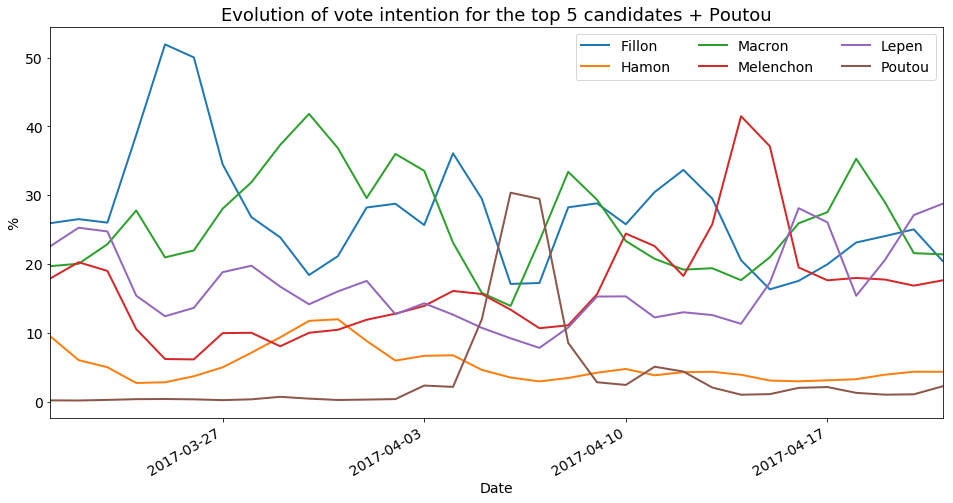

In [8]:
fig, ax = plt.subplots(figsize=(16,8), facecolor='w')
polls.filter(['Fillon', 'Hamon', 'Macron','Melenchon', 'Lepen', 'Poutou']).plot(ax = ax)#
plt.legend(loc='upper right', ncol=3)
plt.title('Evolution of vote intention for the top 5 candidates + Poutou')
plt.xlabel('Date')
plt.ylabel('%')
plt.show()

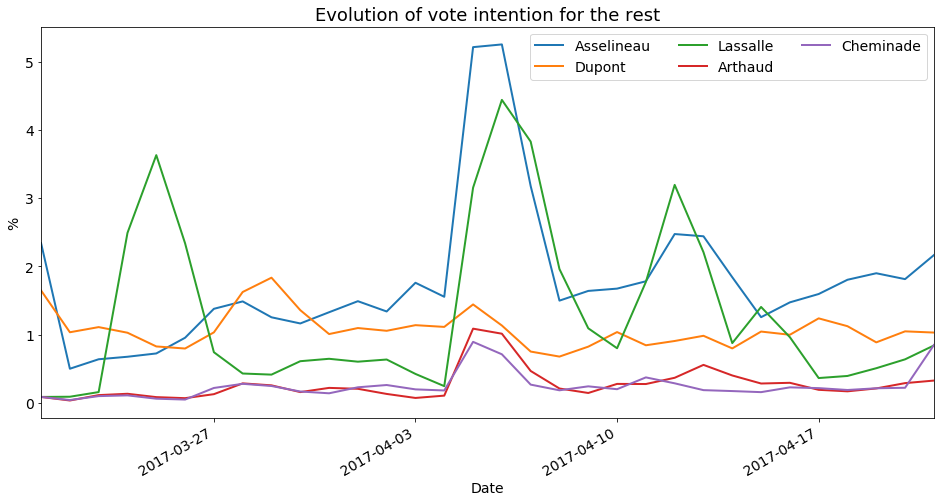

In [15]:
fig, ax = plt.subplots(figsize=(16,8), facecolor='w')
polls.filter(['Asselineau', 'Dupont','Lassalle', 'Arthaud', 'Cheminade']).plot(ax=ax)#
plt.legend(loc='upper right', ncol=3)
plt.title('Evolution of vote intention for the rest')
plt.xlabel('Date')
plt.ylabel('%')
plt.show()

### Second round

In [66]:
second_round = scored_full[constants.FIRST_ROUND+dt.timedelta(days=1):]
second_round['score'] = second_round['score_pos']+second_round['score_neg']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
## Filtering neutral zone
second_round = second_round[(second_round['score']<0) | (second_round['score']>4)]
## Filtering Macron or Lepen
second_round = second_round[(second_round['candidate_ref'] == 'Macron') | (second_round['candidate_ref'] == 'Lepen')]

In [68]:
## Reversing polarity
second_round.loc[(second_round['score']<0) & (second_round['candidate_ref']=='Lepen'), ['candidate_ref', 'score'] ]= ['Macron', 5]
second_round.loc[(second_round['score']<0) & (second_round['candidate_ref']=='Macron'), ['candidate_ref', 'score'] ]= ['Lepen', 5]

In [69]:
polls_2 = generate_polls(dataframe=second_round, bdate=constants.FIRST_ROUND+dt.timedelta(days=1), edate=constants.SECOND_ROUND-dt.timedelta(days=1), step = dt.timedelta(days=1))

In [70]:
polls_2

candidate_ref,Lepen,Macron
2017-04-24 00:00:00,40.000000,60.000000
2017-04-25 00:00:00,37.458430,62.541570
2017-04-26 00:00:00,48.791407,51.208593
2017-04-27 00:00:00,61.058839,38.941161
2017-04-28 00:00:00,56.762661,43.237339
2017-04-29 00:00:00,52.435962,47.564038
2017-04-30 00:00:00,52.708772,47.291228
2017-05-01 00:00:00,51.105844,48.894156
2017-05-02 00:00:00,43.987546,56.012454
2017-05-02 23:59:57,47.570826,52.429174


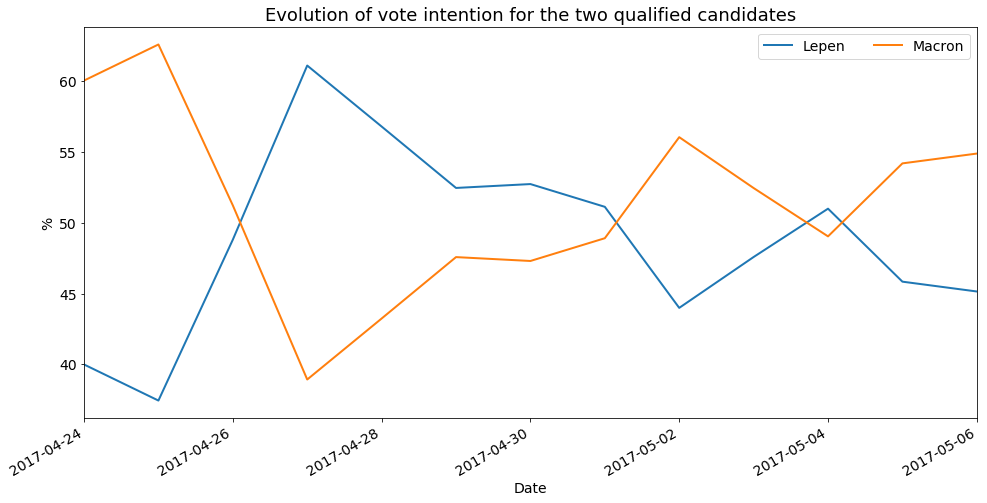

In [71]:
fig, ax = plt.subplots(figsize=(16,8), facecolor='w')
polls_2.plot(ax = ax)#
plt.legend(loc='upper right', ncol=3)
plt.xlabel('Date')
plt.title('Evolution of vote intention for the two qualified candidates')
plt.ylabel('%')
plt.show()

In [72]:
polls_2.iloc[-1]#.plot.pie(autopct='%.2f',figsize=(15,15), legend=False)
#plt.show()

candidate_ref
Lepen     45.14212
Macron    54.85788
Name: 2017-05-06 00:00:00, dtype: float64

In [88]:
get_polls(second_round[:constants.SECOND_ROUND - dt.timedelta(days=1)]).transpose()#.plot.pie(autopct='%.2f')

,id,favoriteCount,retweetCount,relevant_words,score_neg,score_pos,createdAt,score
candidate_ref,,,,,,,,
Lepen,181188,181188,181188,181188,181188,181188,181188,181188
Macron,195010,195010,195010,195010,195010,195010,195010,195010


In [90]:
second_round[:constants.SECOND_ROUND - dt.timedelta(days=1)]

,id,user_id,favoriteCount,retweetCount,candidate_ref,relevant_words,score_neg,score_pos,createdAt,score
createdAt,,,,,,,,,,
2017-04-24 00:00:00,856266430945386505,1321320260,0,0,Macron,"['droit|droite', 'tour', 'Presidentielle2017']",0,6,2017-04-24 00:00:00,6
2017-04-24 00:00:00,856266432417607681,393642791,0,0,Macron,"['moi|mois', 'politique', 'rapport', 'stage', ...",0,9,2017-04-24 00:00:00,9
2017-04-24 00:00:00,856266433067614208,180755493,0,0,Lepen,"['Jul', 'même', 'chose', 'élection', 'sorti', ...",-1,6,2017-04-24 00:00:00,5
2017-04-24 00:00:00,856266432467922944,200899425,0,0,Macron,[''],-2,1,2017-04-24 00:00:00,5
2017-04-24 00:00:00,856266432459440129,3222508488,0,0,Lepen,"['Marine', 'record', 'historique', 'nombre', '...",-1,6,2017-04-24 00:00:00,5
2017-04-24 00:00:01,856266436326682625,701555318812233728,0,0,Lepen,"['tour', 'rentrée', 'devoir', 'réveil', 'heure...",-1,7,2017-04-24 00:00:01,6
2017-04-24 00:00:01,856266435177443328,1455432643,0,0,Macron,"['français', 'loi', 'travail', 'français', 'ge...",0,6,2017-04-24 00:00:01,6
2017-04-24 00:00:01,856266436704165889,1382554556,0,0,Macron,"['meuf', 'potentiel', 'mineur', 'lycée', 'dame...",-1,6,2017-04-24 00:00:01,5
2017-04-24 00:00:01,856266437081649153,2233834636,0,0,Lepen,"['Jul', 'même', 'chose', 'élection', 'sorti', ...",-1,6,2017-04-24 00:00:01,5
